# This notebook is for presenting how our algorithms work real time!

### Let's first create a random King's lattice graph with chosen grid size, and then run the different optimization schemes

In [1]:
using Bloqade
using BloqadeMIS
using Random
using Optim
Random.seed!(42)
using PythonCall
plt = pyimport("matplotlib.pyplot");

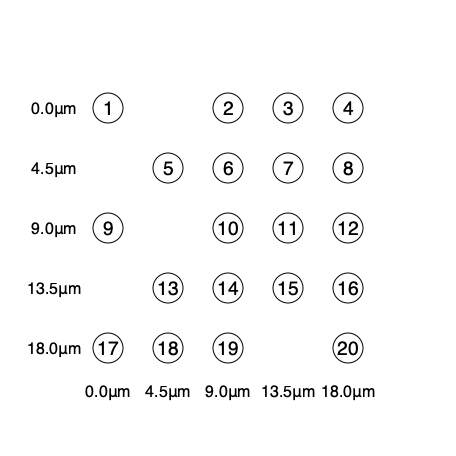

In [2]:
Random.seed!(2)
a=4.5
atoms = generate_sites(SquareLattice(), 5,5; scale = a) |> random_dropout(0.2)

In [3]:
Rb = sqrt(2*sqrt(2))*a

7.568067737283432

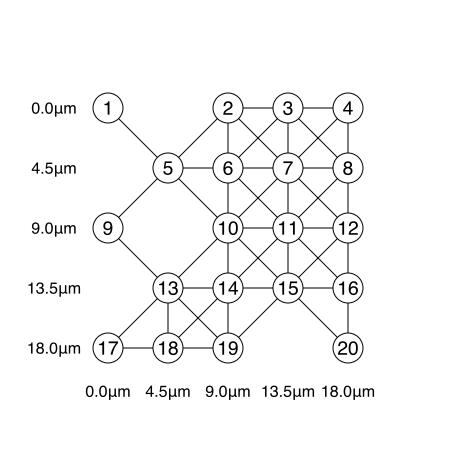

In [5]:
Bloqade.plot(atoms, blockade_radius = Rb)

# QAOA

4.8[0.5, 0.1, 0.5, 0.1, 0.5, 0.1, 0.5, 0.1, 0.5, 0.1, 0.5, 0.1, 0.5, 0.1, 0.5, 0.1][0.0, 0.5, 0.6, 1.1, 1.2, 1.7, 1.8, 2.3, 2.4000000000000004, 2.9000000000000004, 3.0000000000000004, 3.5000000000000004, 3.6000000000000005, 4.1000000000000005, 4.200000000000001, 4.700000000000001, 4.800000000000001]

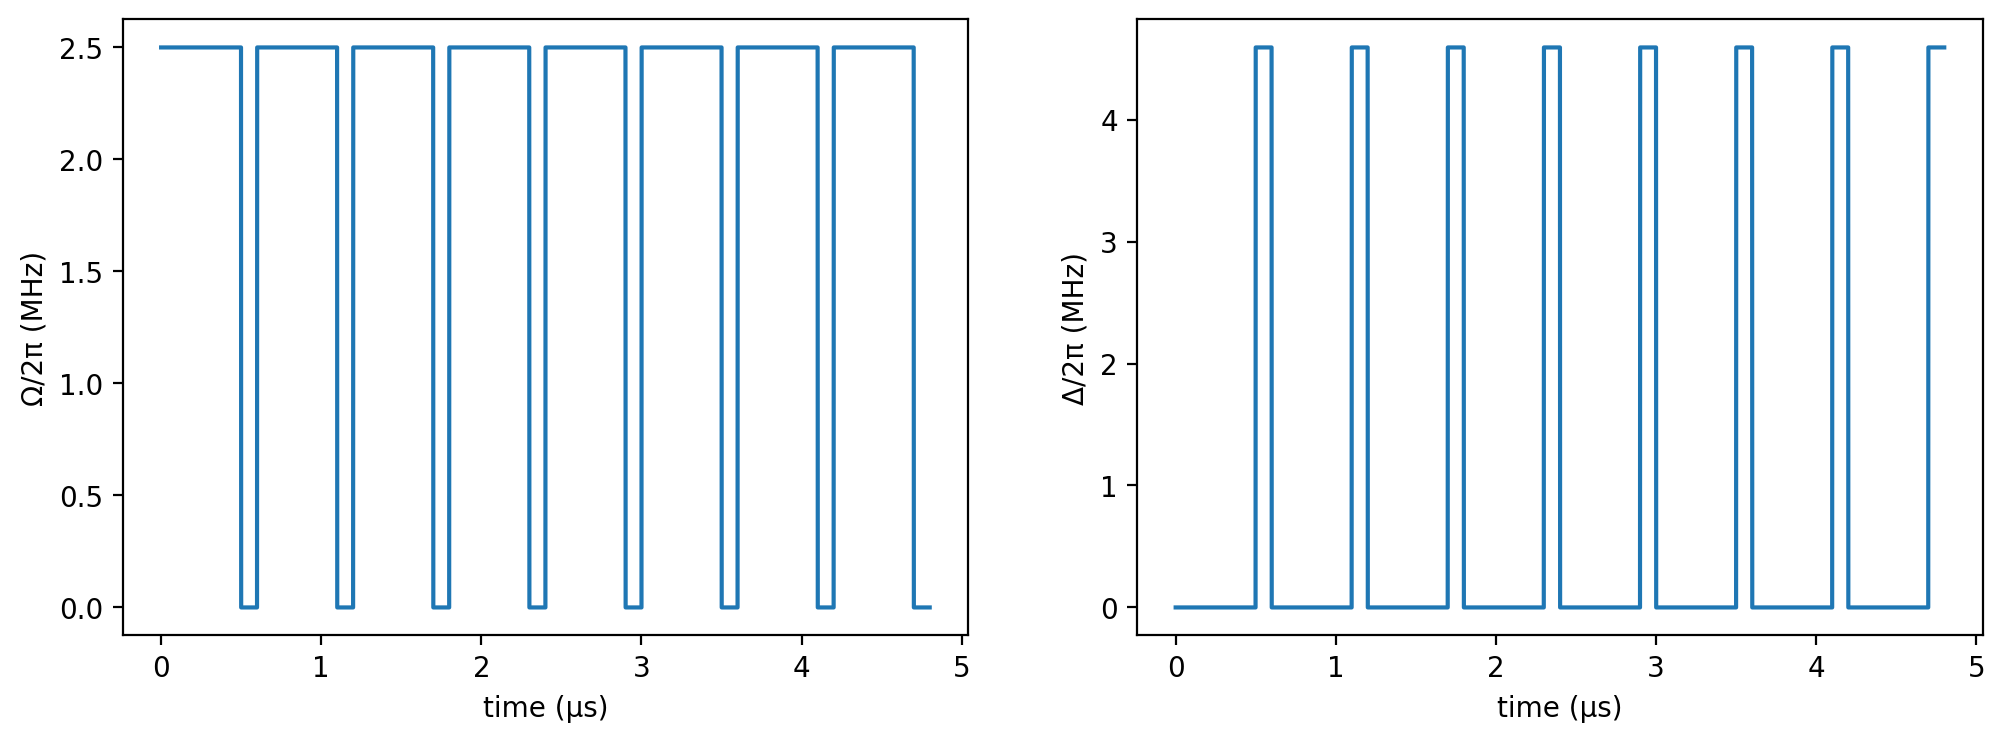

In [6]:
#Total evolution time
T_max = 4.0

#Fix Δ according to the desired Rydberg radius
C6 = 2π * 862690;
Ω_max = 2π*2.5
Δ_max = C6 / Rb^6
Δ_end = Δ_max

# durations = fill(0.5, 8)
durations = [0.5, 0.1, 0.5, 0.1, 0.5, 0.1, 0.5, 0.1, 0.5, 0.1, 0.5, 0.1, 0.5, 0.1, 0.5, 0.1]

clocks = [0, cumsum(durations)...]

Ω2 = piecewise_constant(; clocks = clocks, values = repeat([Ω_max, 0.0], 8))
Δ2 = piecewise_constant(; clocks = clocks, values = repeat([0.0, Δ_end], 8))

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 4))
Bloqade.plot!(ax1, Ω2)
ax1.set_ylabel("Ω/2π (MHz)")
Bloqade.plot!(ax2, Δ2)
ax2.set_ylabel("Δ/2π (MHz)")
fig

In [7]:
function loss_piecewise_constant(atoms::AtomList, x::AbstractVector{T}) where {T}
    @assert length(x) % 2 == 0
    Ω_max = 2π*2.5
    Δ_end = (2π * 862690) / 11.65509028850108^6
    p = length(x) ÷ 2

    # detuning and rabi terms
    durations = abs.(x)   # the durations of each layer of the QAOA pulse take the optimizing vector x as their input
    clocks = [0, cumsum(durations)...]
    Ωs = piecewise_constant(; clocks = clocks, values = repeat(T[Ω_max, 0.0], p))
    Δs = piecewise_constant(; clocks = clocks, values = repeat(T[0.0, Δ_end], p))

    hamiltonian = rydberg_h(atoms; Ω = Ωs, Δ = Δs)
    subspace = blockade_subspace(atoms, 11.65509028850108)  # we run our simulation within the blockade subspace
    prob = KrylovEvolution(zero_state(Complex{T}, subspace), clocks, hamiltonian)
    emulate!(prob)
    return -rydberg_density_sum(prob.reg), prob.reg
end

loss_piecewise_constant (generic function with 1 method)

In [9]:
x0 = durations
rydberg_density, reg1 = loss_piecewise_constant(atoms, x0)
rydberg_density

-2.180919150831547

In [11]:
optresult = Optim.optimize(x -> loss_piecewise_constant(atoms, x)[1], x0)

rydberg_density_final, reg1_final = loss_piecewise_constant(atoms, optresult.minimizer)
rydberg_density_final

In [ ]:
bitstring_hist(reg1_final; nlargest = 20)

In [ ]:
probs(reg1_final)
best_bit_strings = most_probable(reg1_final, 10)